![](https://www.finplus.co.in/wp-content/uploads/2017/10/Top-Categories-In-Online-Retail-In-India.jpg)

### Contexto
<a href="https://drive.google.com/file/d/1T1YHmTUcnOgVfTLnQRtNrzLIgazr2N4S/view?usp=sharing">Online retail es un dataset transaccional</a> que contiene todas las transacciones que ocurrieron entre el 1/12/2010 y el 9/12/2011 en el e-commerce de UK. La compañía vende principalmente regalos y sus clientes tienden a ser revendedores que compran al por mayor.

### Documentación
https://archive.ics.uci.edu/dataset/352/online+retail

### Objetivo de Negocio
"Buscamos segmentar a nuestros clientes para entender sus características y patrones de compra para así poder ofrecerles una mejor experiencia."

**En base a los clusteres creados, expliquenos las características de cada tipo de cliente y qué productos podríamos ofrecerles.**



###Consigna
1. Hacer un breve análisis descriptivo del dataset
2. Al ser un dataset transaccional, hacer todas las modificaciones necesarias para poder utilizarlo (agrupaciones, agregar columnas, etc).
3. Utilizar los métodos de PCA, T-Sne y UMAP para hacer una representación visual del tipo scatterplotdel nuevo dataset creado. Intenta identificar cuantos clusters pueden formarse.
4. Probar los modelos de k-means, clustering jerárquico y dbscan para dividir en clusters, elegir el que mejor resultado les de.
5. En base a los clusteres creados, expliquen las características de cada tipo de cliente y qué productos se podría ofrecerles.

#### 1. Análisis Descriptivo del Dataset

In [75]:
# importamos librerías de análisis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# importamos librerias de modelado
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [76]:
# Leemos el dataset
retail = pd.read_csv('/content/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [79]:
# Vemos la shape, los tipos de dato y las estadísticas de las variables numéricas
display(retail.shape)
display(retail.info())
retail.describe()

(541909, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


None

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [80]:
# Calculamos el % de valores faltantes por columna
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

,0
InvoiceNo,0.00
StockCode,0.00
Description,0.27
Quantity,0.00
InvoiceDate,0.00
UnitPrice,0.00
CustomerID,24.93
Country,0.00


CustomerID tiene nulos y eso para el análisis que buscamos hacer no puede ocurrir. Por eso los eliminaremos. Por otro lado, Description tiene muy pocos valores nulos y al ser insignificantes los eliminaremos también.

In [81]:
# Elimino filas con valores nulos
retail = retail.dropna()
print(retail.shape)
retail.describe()

(406829, 8)


,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


#### 2. Preprocesamiento y agrupamiento

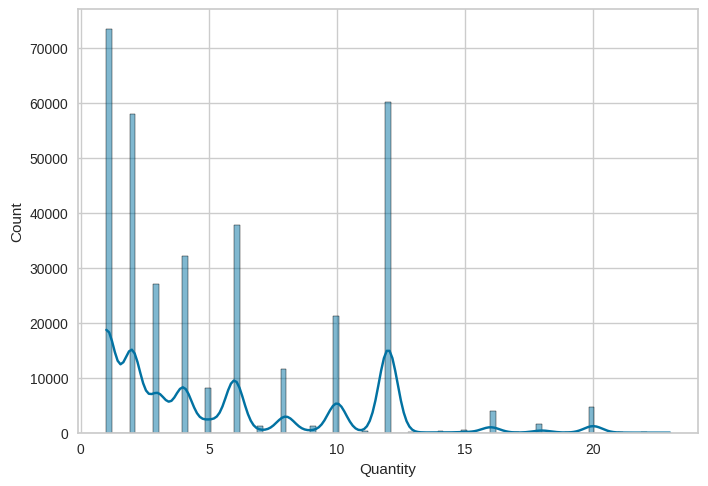

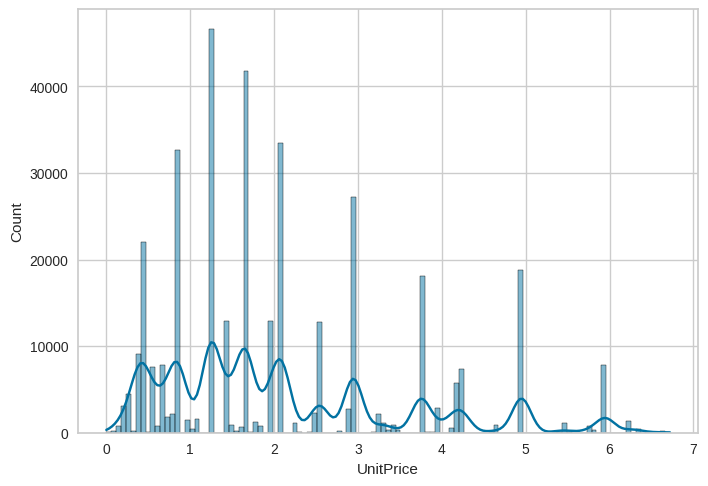

In [82]:
#Chequeo en un gráfico las distribuciones de Quantity y UnitPrice (las features numéricas)

#Elimino valores negativos y arriba del percentil 90% para graficar quantity
quantile_90 = retail['Quantity'].quantile(0.9)
retail_graph = retail[(retail['Quantity'] < quantile_90) & (retail['Quantity'] > 0)]

#elimino valores arriba del percentil 90% para graficar unitprice
quantile_90 = retail['UnitPrice'].quantile(0.9)
retail_graph_2 = retail[retail['UnitPrice'] < quantile_90]

sns.histplot(retail_graph['Quantity'], kde=True)
plt.show()
sns.histplot(retail_graph_2['UnitPrice'], kde=True)
plt.show()

Las órdenes suelen tener cantidades que van de 1 a 12, teniendo cierta preponderancia los pedidos de 1, 2 y 10 cantidades.

Los precios de venta por unidad tienden a ser de pequeña magnitud, principalmente distribuidos entre el 1 y el 2.

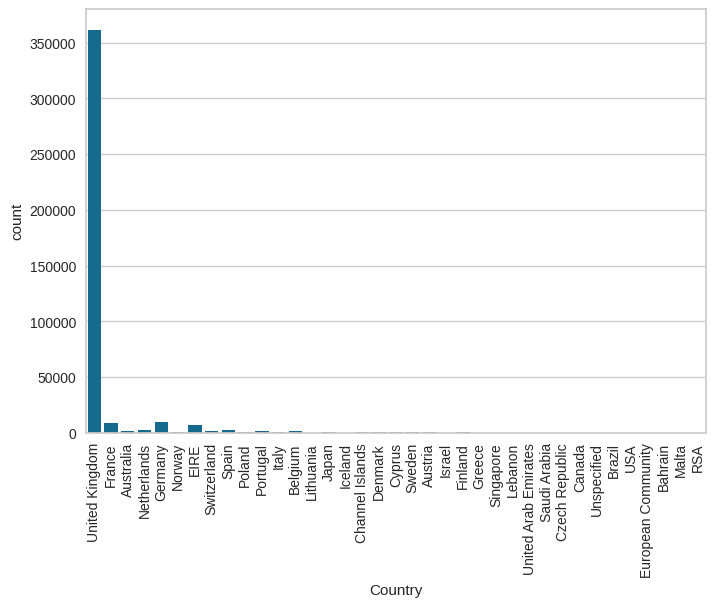

,proportion
Country,
United Kingdom,88.950886
Germany,2.333904
France,2.087118
EIRE,1.839839
Spain,0.622620
Netherlands,0.582800
Belgium,0.508567
Switzerland,0.461373
Portugal,0.363789


In [84]:
#Grafico country
sns.countplot(x='Country', data=retail)
plt.xticks(rotation=90)
plt.show()

#El % de clientes por pais es
dist_paises = retail['Country'].value_counts(normalize=True)*100
dist_paises.head(10)

Al ser el 90% de las transacciones de clientes de UK voy a eliminar country ya que no lo veo como información valiosa.

In [85]:
# Crear variable 'Amount' para representar el valor total por línea
retail['Amount'] = retail['Quantity'] * retail['UnitPrice']
retail = retail[retail['Amount'] > 0]

# Convertir columna de fecha especificando el formato
# La fecha parece estar en formato Día-Mes-Año Hora:Minuto (%d-%m-%Y %H:%M)
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

# Fecha de referencia para calcular recencia
snapshot_date = retail['InvoiceDate'].max()

# Agrupar por cliente y generar múltiples métricas
customers = retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                    # Frequency (facturas únicas)
    'Amount': ['sum'],                          # Monetary total, promedio, desviación
    'Description': 'nunique',                                  # Distintos productos comprados
})

# Renombrar columnas
customers.columns = ['Recency', 'Frequency', 'MonetaryTotal', 'UniqueProducts']
customers = customers.reset_index()
print(customers.shape)
customers.head()

(4338, 5)


,CustomerID,Recency,Frequency,MonetaryTotal,UniqueProducts
0,12346.0,325,1,77183.60,1
1,12347.0,1,7,4310.00,103
2,12348.0,74,4,1797.24,22
3,12349.0,18,1,1757.55,73
4,12350.0,309,1,334.40,17


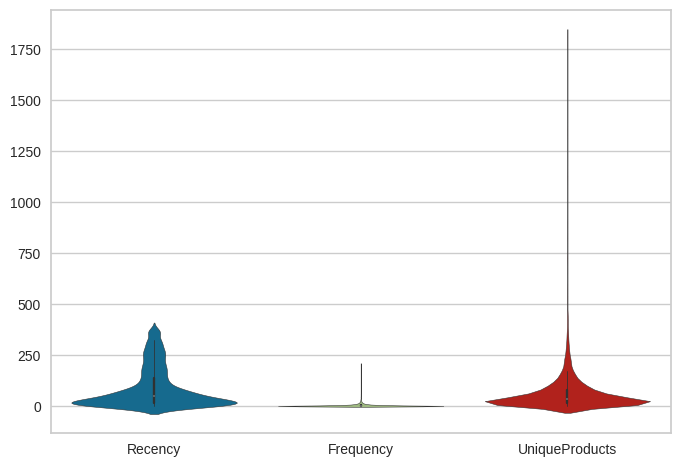

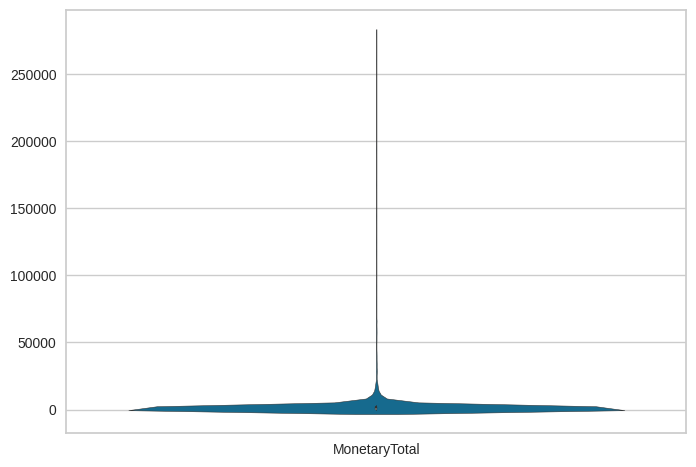

In [88]:
#Uso violinplot para comprobar la presencia de outliers
sns.violinplot(data=customers[['Recency', 'Frequency', 'UniqueProducts']])
plt.show()

sns.violinplot(data=customers[['MonetaryTotal']])
plt.show()

Parece haber presencia de outliers para el número de UniqueProducts, Frequency y MonetaryTotal

In [89]:
#Elimino outliers en Frequency, UniqueProducts y MonetaryTotal usando IQR
customers_clean = customers.copy()
for col in ['Frequency', 'UniqueProducts', 'MonetaryTotal']:
    q1, q3 = customers_clean[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    customers_clean = customers_clean[customers_clean[col].between(q1 - 1.5 * iqr, q3 + 1.5 * iqr)]
    print(f"Outliers eliminados en {col}: {len(customers) - len(customers_clean)}")

print(customers_clean.shape)
customers_clean.describe()

Outliers eliminados en Frequency: 285
Outliers eliminados en UniqueProducts: 553
Outliers eliminados en MonetaryTotal: 838
(3500, 5)


,CustomerID,Recency,Frequency,MonetaryTotal,UniqueProducts
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,15337.118857,106.216000,2.422857,691.508644,37.256571
std,1708.943685,103.589155,1.811980,576.894552,31.458232
min,12348.000000,0.000000,1.000000,3.750000,1.000000
25%,13848.750000,24.000000,1.000000,251.900000,13.000000
50%,15345.500000,64.000000,2.000000,496.935000,28.000000
75%,16805.250000,173.000000,3.000000,977.350000,53.000000
max,18287.000000,373.000000,11.000000,2520.020000,147.000000


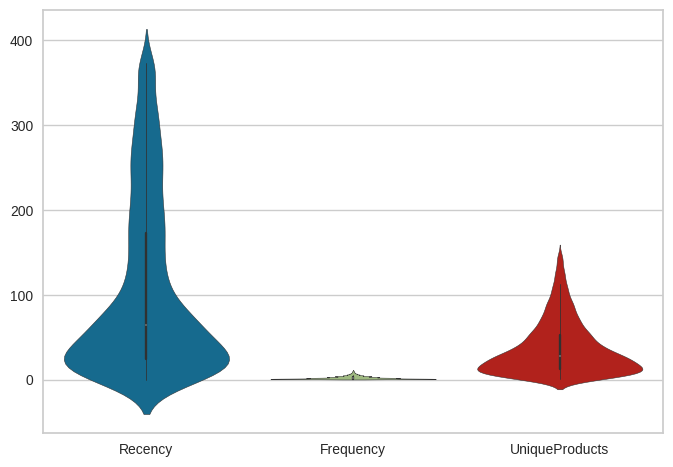

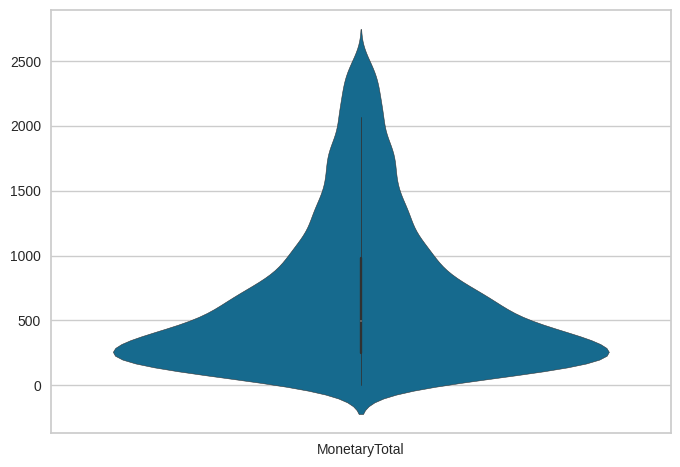

In [90]:
#Uso violinplot para comprobar la presencia de outliers
sns.violinplot(data=customers_clean[['Recency', 'Frequency', 'UniqueProducts']])
plt.show()

sns.violinplot(data=customers_clean[['MonetaryTotal']])
plt.show()

In [91]:
# Normalizar variables para clustering y reducción de dimensionalidad
from sklearn.preprocessing import StandardScaler
features = customers_clean.drop('CustomerID', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
print(scaled_features.shape)
scaled_features

(3500, 4)


array([[-0.31104225,  0.8705217 ,  1.91696966, -0.48504797],
       [-0.85171662, -0.78536197,  1.84816042,  1.13638097],
       [ 1.95785916, -0.78536197, -0.61910737, -0.64401159],
       ...,
       [ 0.71237711, -0.78536197, -1.05873058, -0.96193883],
       [-0.95792052, -0.23340075, -0.89016616, -0.80297521],
       [-0.61999903,  0.31856048,  1.98638567,  0.69128283]])

#### 3. Visualización usando PCA, TSNE y UMAP

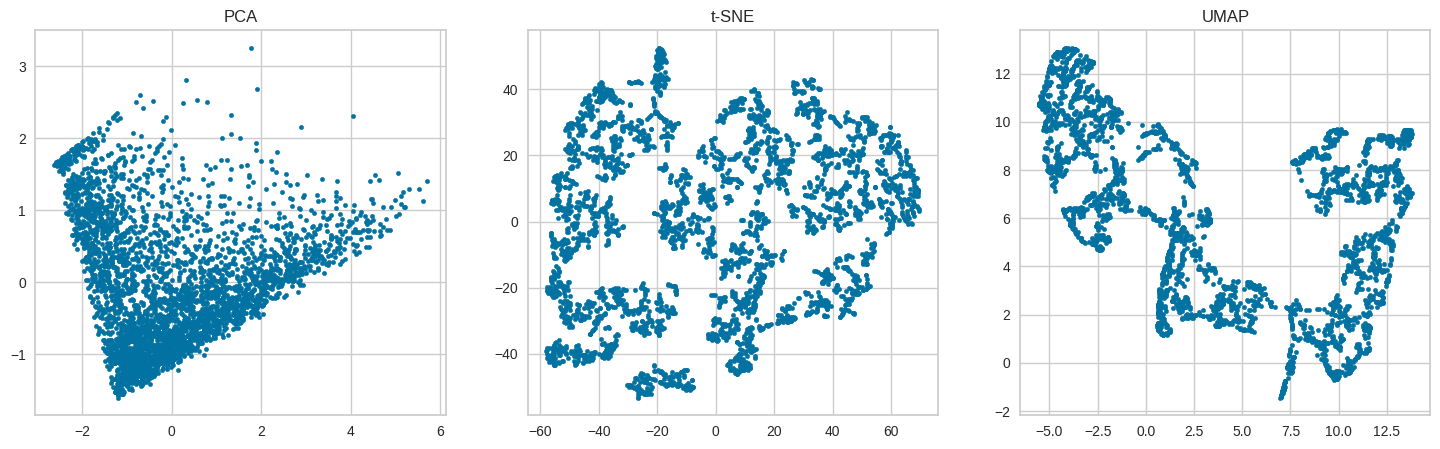

In [92]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt

#Elimino outliers para poder visualizar mejor

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# t-SNE (con hiperparámetros optimizados)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_result = reducer.fit_transform(scaled_features)

# Visualización comparativa
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].scatter(pca_result[:,0], pca_result[:,1], s=10)
axs[0].set_title("PCA")
axs[1].scatter(tsne_result[:,0], tsne_result[:,1], s=10)
axs[1].set_title("t-SNE")
axs[2].scatter(umap_result[:,0], umap_result[:,1], s=10)
axs[2].set_title("UMAP")
plt.show()

Se puede ver al menos 2 o 3 grupos con PCA y alrededor de 4 con UMAP, aunque no hay tanta claridad. Va a ser importante probar con distintos k al clusterizar.

####4. Aplicamos modelos de clustering

##### K-Means

Método del Codo para determinar el número de clusters a formar:


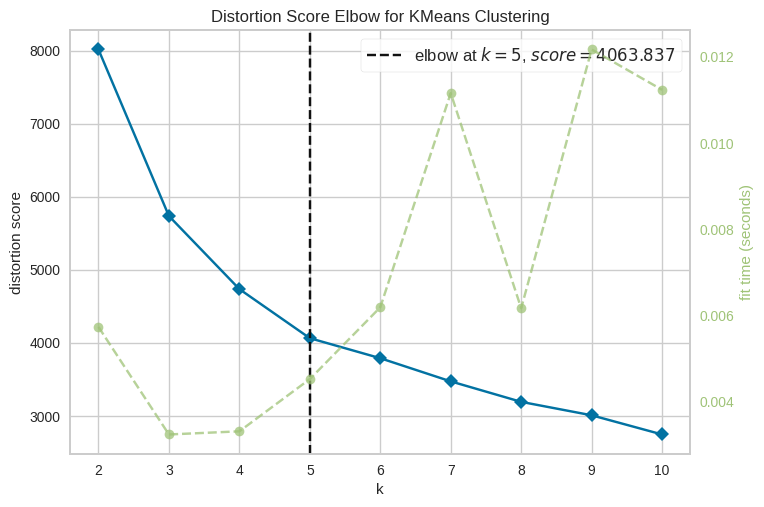

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
# K-MEANS: Usamos el método del codo para determinar K óptimo
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Examinando rápidamente el método del codo para encontrar el número de clusters a crear.
print('Método del Codo para determinar el número de clusters a formar:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(scaled_features)
Elbow_M.show()

Text(0.5, 1.0, 'Silhouette Score para diferentes valores de k')

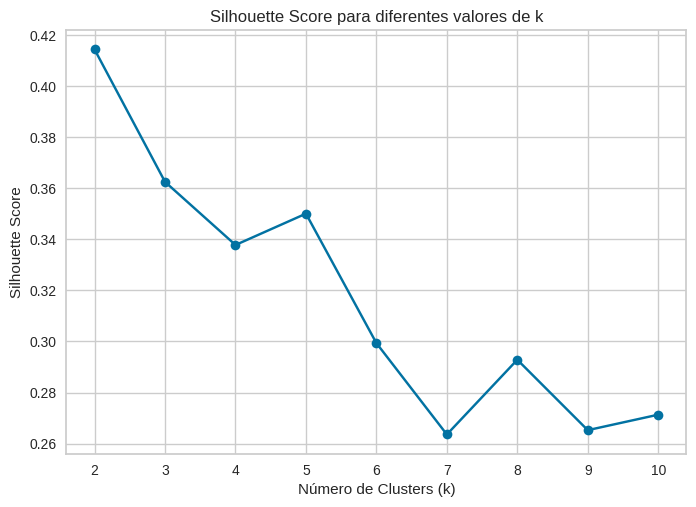

In [100]:
#Calculamos silhouette para k-means de 2 a 10 clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

#Visualizamos cuál es el k y su silhouetee
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes valores de k')

k = 5 tiene un buen valor de inercia y vemos que también de silhouette. A pesar de que k=2 y k=3 tienen mejores silhouettes, elijo k=5 porque me permite separar en más clusters y ganar mejores insights de kis clientes

In [103]:
# Elegimos K = 5 (por ejemplo), evaluamos con silhouette
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
silhouette_avg_kmeans = silhouette_score(scaled_features, kmeans_labels)
print(f"Silhouette Score para K-means (K=5): {silhouette_avg_kmeans:.3f}")

#Vemos la cantidad de valores por label
unique, counts = np.unique(kmeans_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

Silhouette Score para K-means (K=5): 0.350
[[   0  880]
 [   1  326]
 [   2  334]
 [   3 1285]
 [   4  675]]


##### Jerárquico

Text(0.5, 1.0, 'Silhouette Score para diferentes valores de k')

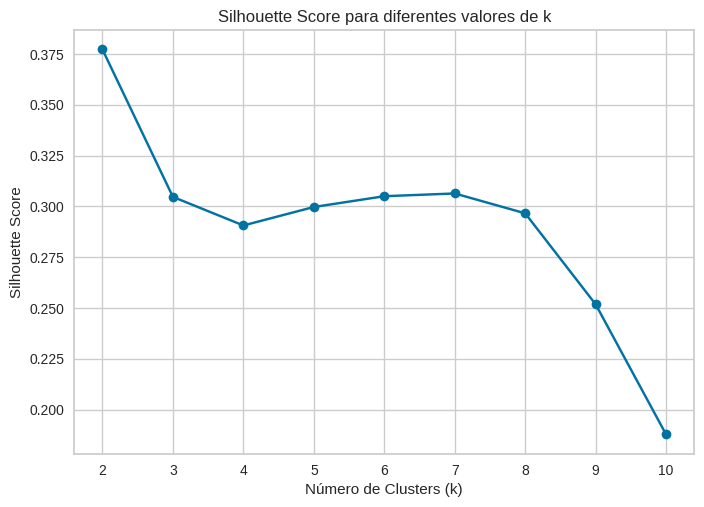

In [108]:
#Calculamos silhouette para jerarquico de 2 a 10 clusters
silhouette_scores = []
for k in range(2, 11):
    agglo = AgglomerativeClustering(n_clusters=k)
    agglo_labels = agglo.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, agglo_labels)
    silhouette_scores.append(silhouette_avg)

#Visualizamos cuál es el k y su silhouetee
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes valores de k')

Probamos viendo la separación en 5, 6 y 7 clusters:

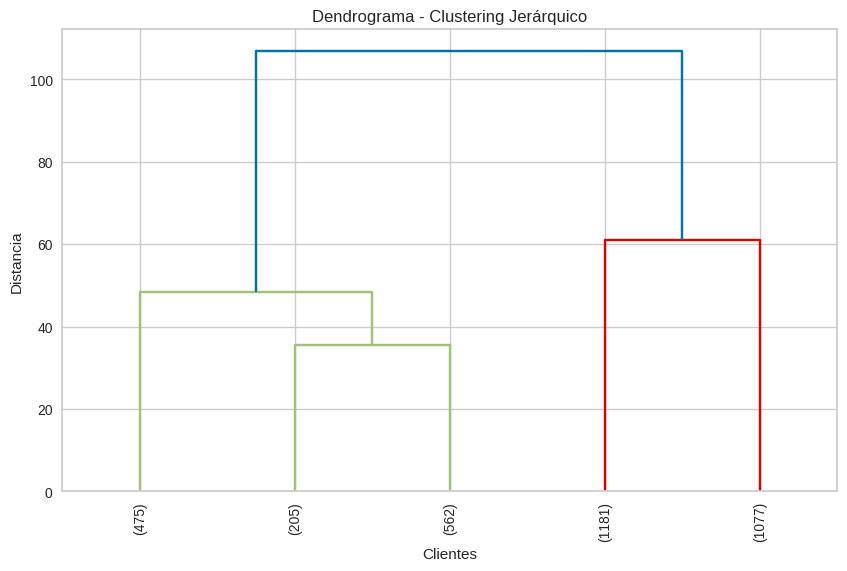

In [109]:
# Clustering jerárquico - Dendrograma
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='lastp', p=5, leaf_rotation=90., leaf_font_size=10.)
plt.title('Dendrograma - Clustering Jerárquico')
plt.xlabel('Clientes')
plt.ylabel('Distancia')
plt.show()

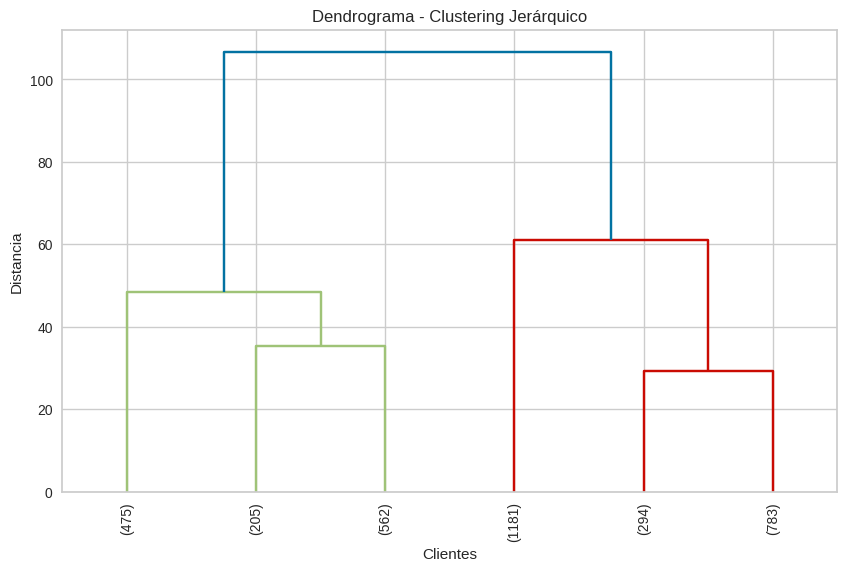

In [110]:
# Clustering jerárquico - Dendrograma
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='lastp', p=6, leaf_rotation=90., leaf_font_size=10.)
plt.title('Dendrograma - Clustering Jerárquico')
plt.xlabel('Clientes')
plt.ylabel('Distancia')
plt.show()

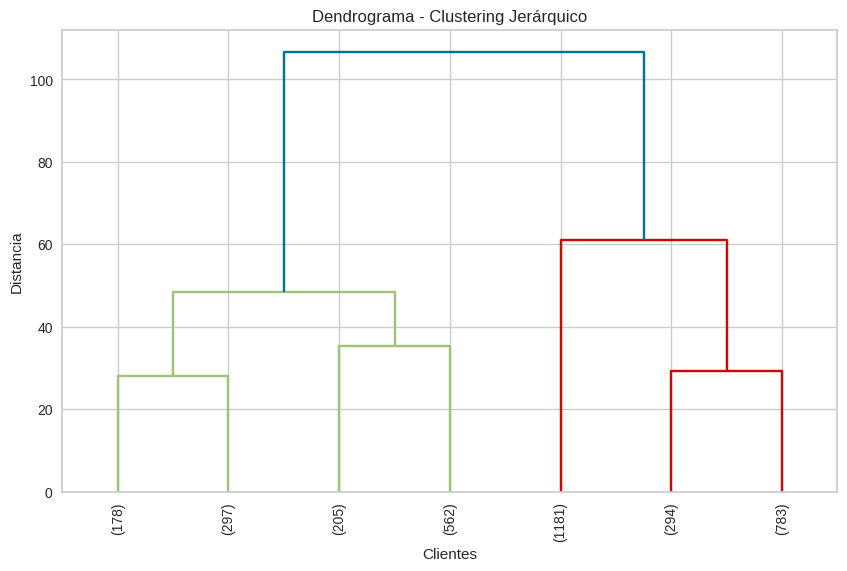

In [111]:
# Clustering jerárquico - Dendrograma
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='lastp', p=7, leaf_rotation=90., leaf_font_size=10.)
plt.title('Dendrograma - Clustering Jerárquico')
plt.xlabel('Clientes')
plt.ylabel('Distancia')
plt.show()

Descartamos la separación en 7 clusters ya que a pesar de tener un silhouette más alto, nos quedan varios clusters chicos.

Las separaciones de 5 y 6 clusters son parecidas y ambas podrían ser válidas. Nos quedamos con 5 para tener un punto en común con k-means.

In [112]:
from sklearn.cluster import AgglomerativeClustering
# Evaluamos clustering jerárquico con 5 clusters
agglo = AgglomerativeClustering(n_clusters=5)
agglo_labels = agglo.fit_predict(scaled_features)
silhouette_avg_agglo = silhouette_score(scaled_features, agglo_labels)
print(f"Silhouette Score para Clustering Jerárquico: {silhouette_avg_agglo:.3f}")

#Vemos la cantidad de valores por label
unique, counts = np.unique(agglo_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

Silhouette Score para Clustering Jerárquico: 0.300
[[   0 1077]
 [   1  475]
 [   2 1181]
 [   3  562]
 [   4  205]]


##### DBSCAN

In [130]:
#Busco la combinación que me dé un mejor silhouette
from sklearn.cluster import DBSCAN

eps_values = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_values = [5, 10, 15, 20]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_features)

        n_outliers = np.sum(labels == -1)
        valid_labels = labels[labels != -1]
        n_clusters = len(np.unique(valid_labels))

        if n_clusters > 1:
            score = silhouette_score(scaled_features[labels != -1], valid_labels)
        else:
            score = np.nan

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'clusters': n_clusters,
            'outliers': n_outliers,
            'silhouette': round(score, 3) if not np.isnan(score) else np.nan
        })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='silhouette', ascending=False)

# Mostrar con 'N/A' en vez de NaN para visualización
df_results_display = df_results.copy()
df_results_display['silhouette'] = df_results_display['silhouette'].fillna('N/A')

display(df_results_display)

,eps,min_samples,clusters,outliers,silhouette
12,0.6,5,4,182,0.41
14,0.6,15,2,485,0.388
16,0.7,5,2,83,0.225
3,0.3,20,3,1972,0.082
7,0.4,20,4,1355,0.076
10,0.5,15,5,867,0.073
6,0.4,15,5,1214,0.066
9,0.5,10,8,647,0.06
11,0.5,20,7,1017,0.059
5,0.4,10,8,1009,0.057


In [131]:
# DBSCAN - uso eps 0,6 y min_samples 5
dbscan = DBSCAN(eps=0.6, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_features)

print(f"Número de clusters encontrados por DBSCAN: {len(np.unique(dbscan_labels))}")
#Numero de valores por cluster
unique, counts = np.unique(dbscan_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

# Etiquetas diferentes a -1 (outliers)
valid_labels = dbscan_labels[dbscan_labels != -1]
if len(np.unique(valid_labels)) > 1:
    silhouette_avg_dbscan = silhouette_score(scaled_features[dbscan_labels != -1], valid_labels)
    print(f"Silhouette Score para DBSCAN: {silhouette_avg_dbscan:.3f}")
else:
    print("DBSCAN encontró solo un cluster o muchos outliers, no se puede calcular Silhouette.")

Número de clusters encontrados por DBSCAN: 5
[[  -1  182]
 [   0 3299]
 [   1   10]
 [   2    5]
 [   3    4]]
Silhouette Score para DBSCAN: 0.410


Me quedan 3 clusters muy pequeños lo que no me sirve. Y el resto de las combinaciones con silhouete arriba de 0,1 separan en sólo 2 clusters

In [135]:
# DBSCAN - uso eps 0,5 y min_samples 15 que a pesar de tener bajo silhouette, separa en 5 clusters
dbscan = DBSCAN(eps=0.5, min_samples=15)
dbscan_labels = dbscan.fit_predict(scaled_features)

print(f"Número de clusters encontrados por DBSCAN: {len(np.unique(dbscan_labels))}")
#Numero de valores por cluster
unique, counts = np.unique(dbscan_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

# Etiquetas diferentes a -1 (outliers)
valid_labels = dbscan_labels[dbscan_labels != -1]
if len(np.unique(valid_labels)) > 1:
    silhouette_avg_dbscan = silhouette_score(scaled_features[dbscan_labels != -1], valid_labels)
    print(f"Silhouette Score para DBSCAN: {silhouette_avg_dbscan:.3f}")
else:
    print("DBSCAN encontró solo un cluster o muchos outliers, no se puede calcular Silhouette.")

Número de clusters encontrados por DBSCAN: 6
[[  -1  867]
 [   0 1381]
 [   1  691]
 [   2  189]
 [   3  318]
 [   4   54]]
Silhouette Score para DBSCAN: 0.073


DBSCAN tiene el peor coeficiente de Silhouette lo que nos indica que la separación que hace no es muy buena

##### Seleccion de modelo

In [136]:
#Comparo el silhouette de los 3 modelos
print(f"Silhouette Score para K-means: {silhouette_avg_kmeans:.3f}")
print(f"Silhouette Score para Clustering Jerárquico: {silhouette_avg_agglo:.3f}")
print(f"Silhouette Score para DBSCAN: {silhouette_avg_dbscan:.3f}")

Silhouette Score para K-means: 0.350
Silhouette Score para Clustering Jerárquico: 0.300
Silhouette Score para DBSCAN: 0.073


K-means tiene el silhouette más alto y una buena distribución en cantidad de valores por cluster. Entonces me voy a quedar con el clusterizado por este método.

#### 5. Interpretación de Clusters y selección de estrategias

In [141]:
# Asignamos los clusters de K-means, Hierarchical y DBSCAN al dataset original para análisis
customers_clean['Kmeans'] = kmeans_labels
customers_clean.head()

,CustomerID,Recency,Frequency,MonetaryTotal,UniqueProducts,Kmeans
2,12348.0,74,4,1797.24,22,4
3,12349.0,18,1,1757.55,73,2
4,12350.0,309,1,334.40,17,0
5,12352.0,35,8,2506.04,59,1
6,12353.0,203,1,89.00,4,0


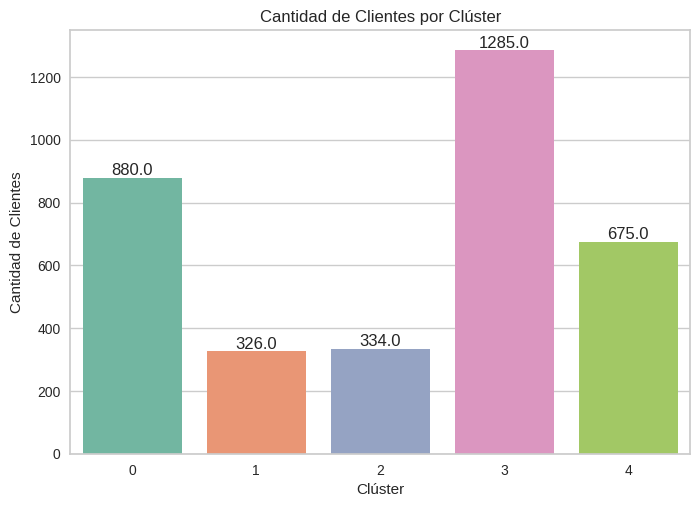

In [150]:
#Gráfico de cantidad de valores por cluster con distitnos colores y etiquetas
ax = sns.countplot(x='Kmeans', data=customers_clean, palette='Set2')
for p in ax.patches: ax.annotate(f'{p.get_height()}', (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom')
ax.set(title='Cantidad de Clientes por Clúster', xlabel='Clúster', ylabel='Cantidad de Clientes')
plt.show()

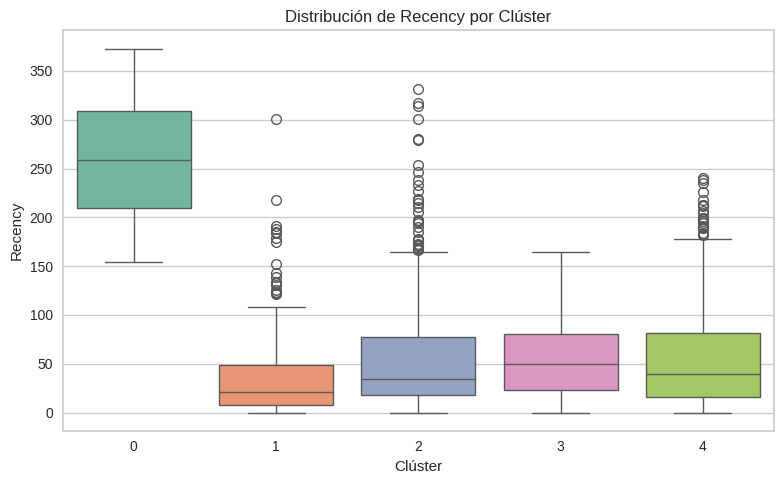

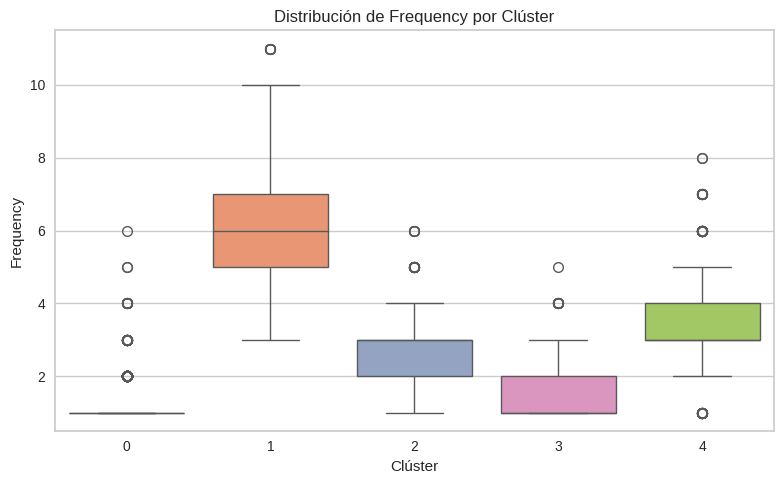

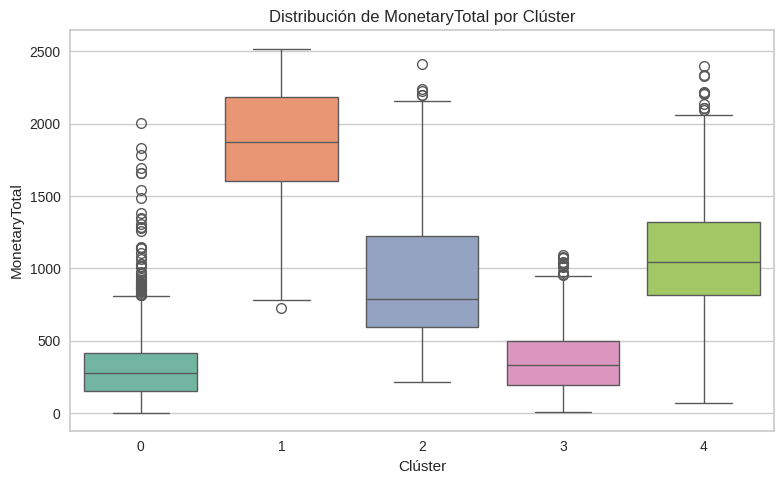

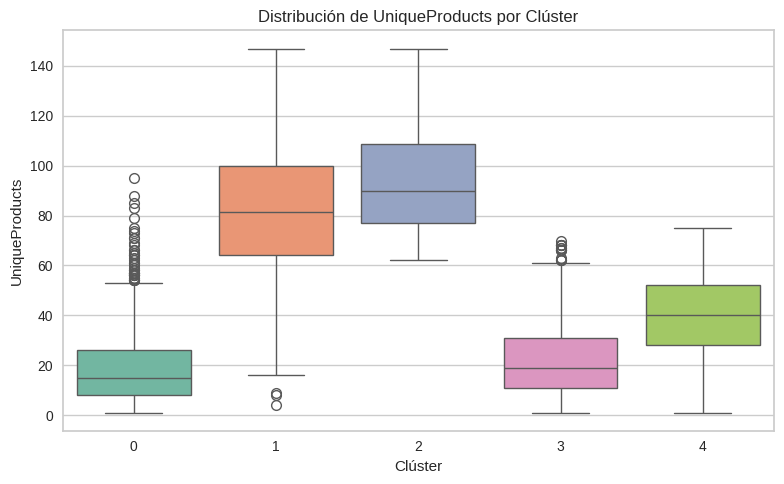

In [151]:
#Visualizamos cada dataset

cols = ['Recency', 'Frequency', 'MonetaryTotal', 'UniqueProducts']

# Creamos una figura por variable
for col in cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=customers_clean, x='Kmeans', y=col, palette='Set2')
    plt.title(f'Distribución de {col} por Clúster')
    plt.xlabel('Clúster')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

### Interpretación de Clústeres y Recomendaciones

---

#### **Clúster 0 – Clientes Inactivos**  
**Cantidad:** 880 clientes  
**Perfil:** Clientes que no compran hace más de 10 meses, realizaron muy pocas compras, con bajo gasto y escasa variedad de productos.  
**Recomendación:**  
Implementar campañas de reactivación mediante ofertas exclusivas, recordatorios personalizados y novedades destacadas. Evaluar la conveniencia de seguir invirtiendo en este segmento.

---

#### **Clúster 1 – Clientes Estrella**  
**Cantidad:** 326 clientes  
**Perfil:** Clientes altamente valiosos: compran con frecuencia, su última compra fue reciente, realizan grandes gastos y consumen una amplia variedad de productos.  
**Recomendación:**  
Conservar su fidelidad a través de beneficios especiales, programas de recompensas y comunicación personalizada. Representan el segmento más rentable.

---

#### **Clúster 2 – Frecuentes de Bajo Gasto**  
**Cantidad:** 334 clientes  
**Perfil:** Compran seguido y eligen productos variados, pero con un gasto total relativamente bajo.  
**Recomendación:**  
Aplicar estrategias de **upselling** y **cross-selling**, como sugerencias de productos relacionados, promociones por monto mínimo o packs premium.

---

#### **Clúster 3 – Nuevos o de Bajo Compromiso**  
**Cantidad:** 1.285 clientes  
**Perfil:** Han realizado compras recientes, pero con baja frecuencia, poco gasto y poca diversidad de productos.  
**Recomendación:**  
Desarrollar campañas de bienvenida y educación del cliente. Enviar recomendaciones personalizadas y automatizar seguimientos para fomentar una segunda compra.

---

#### **Clúster 4 – Clientes con Potencial**  
**Cantidad:** 675 clientes  
**Perfil:** Compran con frecuencia media-alta, muestran un gasto significativo y buena variedad de productos. Están cerca de convertirse en clientes estrella.  
**Recomendación:**  
Impulsar su crecimiento mediante promociones personalizadas, incentivos por recurrencia y seguimiento proactivo para potenciar su valor a largo plazo.
